# Comparison of assimilation procedures

In the previous tutorial, we implemented a PGM for the Robot Pathing example and leveraged it during assimilation.  

This notebook will compare the assimilation procedure employed by the plain RobotPathingEnv, which only employs the inverse problem solution of multiple sensor readings, against the usage of a PGM.  

We start by evaluating the accuracy of the assimilation step for the baseline environment.

In [1]:
import gymnasium as gym

from examples.robot_pathing.common import RobotPathingEnv

n_simulation_iters = 200
n_obs_assimilation = 5

env = gym.make(
    "robot_pathing",
    noise_type="gaussian",
    state_update_type="deterministic",
    n_obs_assimilation=n_obs_assimilation,
    max_episode_steps=n_simulation_iters,
)

/home/yaevon/miniforge3/envs/dtlib/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We define here an helper function to perform the simulation of a given environment, always with the same policy.  

In [2]:
import numpy as np
from examples.robot_pathing.common import RobotPathingSetup, RobotPathingPolicy

setup = RobotPathingSetup()


def eval_env(
    env: RobotPathingEnv,
    physical_state: np.ndarray = np.array([0, 0]),
    seed: int = None,
):
    policy = RobotPathingPolicy(
        setup.state_domain,
        actions=setup.actions,
        goals=setup.goals_coords,
    )

    obs, info = env.reset(seed=seed, options={"physical_state": physical_state})

    goals = [policy.get_current_goal()]
    pstates = [info["physical_state"]]
    dstates = [setup.state_domain.index2values(np.argmax(obs))]

    action, _ = policy.predict(obs, deterministic=True)

    actions = [setup.actions[0].name]

    for f in range(n_simulation_iters):
        obs, _, terminated, truncated, info = env.step(action)

        goals.append(policy.get_current_goal())
        pstates.append(info["physical_state"])
        dstates.append(setup.state_domain.index2values(np.argmax(obs)))

        action, _ = policy.predict(obs, deterministic=True)

        actions.append(setup.actions[action].name)

        if terminated or truncated:
            break

    return (
        pstates,
        dstates,
        goals,
        actions,
    )


pstates, dstates, goals, actions = eval_env(env, seed=42)


We re-define the RobotPathingPGMEnv from the previous tutorial, but this time we leverage the PGMHelper from examples.robot_pathing.common  

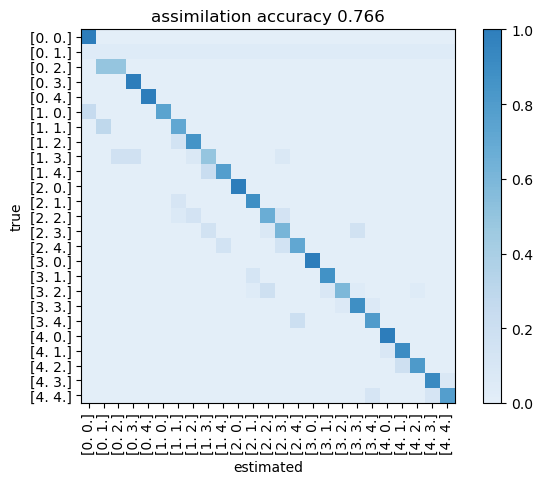

In [3]:
from matplotlib import pyplot as plt
from pgmtwin.core.utils import plot_discrete_domain_confusion_matrix

n_states = len(setup.state_domain)
n_actions = len(setup.action_domain)

assimilation_conf_matrix = np.zeros((n_states, n_states))
for i, j in zip(
    setup.state_domain.values2index(pstates), setup.state_domain.values2index(dstates)
):
    assimilation_conf_matrix[i, j] += 1


plot_discrete_domain_confusion_matrix(setup.state_domain, assimilation_conf_matrix)

accuracy = np.sum(np.diag(assimilation_conf_matrix)) / len(dstates)
plt.title(f"assimilation accuracy {accuracy:.3f}")
assimilation_conf_matrix_baseline = assimilation_conf_matrix

plt.show()
plt.close()

We re-define the RobotPathingPGMEnv from the previous tutorial, but this time we leverage the PGMHelper from examples.robot_pathing.common  
This environment also supports parallel operation during inference, where the samples drawn from the (D_I, 1) and (D, 0) distributions are split over multiple workers.  
However, this parallel infrastructure adds a hefty overhead.  

In [4]:
from typing import Optional
from pgmpy.inference import DBNInference
from pgmtwin.core.utils import pgmpy_suppress_cpd_replacement_warning
from examples.robot_pathing.common import RobotPathingEnv, RobotPathingPGMHelper


class RobotPathingPGMEnv(RobotPathingEnv):
    def __init__(
        self,
        noise_type: str,
        state_update_type: str,
        n_obs_assimilation: int = 1,
        pgm_n_samples_assimilation: int = 1,
        pgm_n_workers: Optional[int] = 1,
        inv_solver_confusion_matrix: Optional[np.ndarray] = None,
    ):
        super().__init__(
            noise_type=noise_type,
            state_update_type=state_update_type,
            n_obs_assimilation=n_obs_assimilation,
            inv_solver_confusion_matrix=inv_solver_confusion_matrix,
        )

        setup = RobotPathingSetup()

        pgm_helper = None
        dbn = None
        dbn_infer = None
        if pgm_n_samples_assimilation > 0:
            pgm_helper = RobotPathingPGMHelper(
                self._state_domain,
                self._actions,
                n_beacons=len(setup.beacons_coords),
            )
            dbn = pgm_helper.init_dbn_assimilation()
            dbn.initialize_initial_state()

            with pgmpy_suppress_cpd_replacement_warning():
                dbn_infer = DBNInference(dbn)

        self.pgm_helper = pgm_helper
        self.dbn = dbn
        self.dbn_infer = dbn_infer
        self.pgm_n_samples_assimilation = pgm_n_samples_assimilation
        self.pgm_n_workers = pgm_n_workers

    def _step_assimilate(self, action: Optional[int], sensor_readings: np.ndarray):
        if not self.pgm_helper:
            super()._step_assimilate(action, sensor_readings)
        else:
            self.pgm_helper.assimilate(
                dbn_infer=self.dbn_infer,
                action_history=[action if action is not None else 0],
                sensor_readings=sensor_readings,
                digital_asset=self._digital_asset,
                n_samples=self.pgm_n_samples_assimilation,
                n_workers=self.pgm_n_workers,
                rng=self.np_random,
            )


if "robot_pathing_pgm" not in gym.registry:
    gym.register("robot_pathing_pgm", RobotPathingPGMEnv)

As with the baseline environment, we simulate the PGM environment with the same inputs and compute the assimilation step's confusion matrix.  
We load the confusion matrix for the inverse problem solver that was created with the previous tutorial notebook.  

In [5]:
import os

inv_solver_conf_matrix_fname = os.path.join(
    "..", "examples", "robot_pathing", "inverse_solver_conf_matrix.npy"
)

inv_solver_conf_matrix = np.load(inv_solver_conf_matrix_fname)

pgm_env = gym.make(
    "robot_pathing_pgm",
    noise_type="gaussian",
    state_update_type="deterministic",
    n_obs_assimilation=n_obs_assimilation,
    pgm_n_samples_assimilation=5,
    inv_solver_confusion_matrix=inv_solver_conf_matrix,
    max_episode_steps=n_simulation_iters,
)

In [6]:
pstates, dstates, goals, actions = eval_env(pgm_env, seed=42)

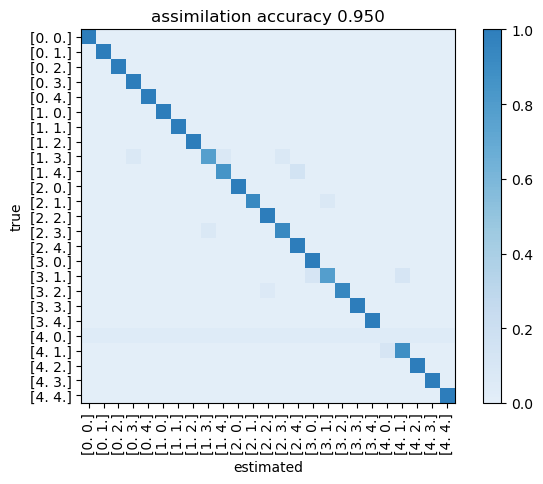

In [7]:
assimilation_conf_matrix = np.zeros((n_states, n_states))
for i, j in zip(
    setup.state_domain.values2index(pstates), setup.state_domain.values2index(dstates)
):
    assimilation_conf_matrix[i, j] += 1

plot_discrete_domain_confusion_matrix(setup.state_domain, assimilation_conf_matrix)

accuracy = np.sum(np.diag(assimilation_conf_matrix)) / len(dstates)
plt.title(f"assimilation accuracy {accuracy:.3f}")
assimilation_conf_matrix_pgm = assimilation_conf_matrix

plt.show()
plt.close()

The accuracy is much higher than with the baseline, thanks to the PGM's access to the actions' transitions.  

We now perform a more complete test to compare the effects of the sample size in the PGM inference.  
Due to the nature of the noise, sampling sizes above 9 seems to introduce noise rather than further refining the assimilation.  

In [8]:
import time

import pandas as pd

pgm_samples = [1, 2, 5, 10, 20]
n_repeats = 10

env = gym.make(
    "robot_pathing",
    noise_type="gaussian",
    state_update_type="deterministic",
    n_obs_assimilation=n_obs_assimilation,
    max_episode_steps=n_simulation_iters,
)

dfdict = {
    "assimilation": [],
    "n_obs_samples": [],
    "n_pgm_samples": [],
    "accuracy": [],
    "iter_time": [],
}

for _ in range(n_repeats):
    elapsed = -time.perf_counter()
    pstates, dstates, goals, actions = eval_env(env)
    elapsed += time.perf_counter()

    pstates = setup.state_domain.values2index(pstates)
    dstates = setup.state_domain.values2index(dstates)

    accuracy = np.sum(pstates == dstates) / len(pstates)

    dfdict["assimilation"].append("baseline")
    dfdict["n_obs_samples"].append(n_obs_assimilation)
    dfdict["n_pgm_samples"].append(0)
    dfdict["accuracy"].append(accuracy)
    dfdict["iter_time"].append(elapsed / len(pstates))

    run = f"baseline obs[{n_obs_assimilation}]"
    print(
        f"run {run} accuracy {accuracy:.3f} took {elapsed:.3f} per iter {elapsed/len(pstates):.3f}"
    )

for n_pgm_samples in pgm_samples:
    pgm_env = gym.make(
        "robot_pathing_pgm",
        noise_type="gaussian",
        state_update_type="deterministic",
        n_obs_assimilation=n_obs_assimilation,
        pgm_n_samples_assimilation=n_pgm_samples,
        max_episode_steps=n_simulation_iters,
    )

    for _ in range(n_repeats):
        elapsed = -time.perf_counter()
        pstates, dstates, goals, actions = eval_env(pgm_env)
        elapsed += time.perf_counter()

        pstates = setup.state_domain.values2index(pstates)
        dstates = setup.state_domain.values2index(dstates)

        accuracy = np.sum(pstates == dstates) / len(pstates)

        dfdict["assimilation"].append("pgm")
        dfdict["n_obs_samples"].append(n_obs_assimilation)
        dfdict["n_pgm_samples"].append(n_pgm_samples)
        dfdict["accuracy"].append(accuracy)
        dfdict["iter_time"].append(elapsed / len(pstates))

        run = f"pgm obs[{n_obs_assimilation}] pgm[{n_pgm_samples}]"
        print(
            f"run {run} accuracy {accuracy:.3f} took {elapsed:.3f} per iter {elapsed/len(pstates):.3f}"
        )

stats_df = pd.DataFrame(dfdict)

run baseline obs[5] accuracy 0.776 took 0.079 per iter 0.000
run baseline obs[5] accuracy 0.716 took 0.079 per iter 0.000
run baseline obs[5] accuracy 0.716 took 0.079 per iter 0.000
run baseline obs[5] accuracy 0.731 took 0.081 per iter 0.000
run baseline obs[5] accuracy 0.741 took 0.085 per iter 0.000
run baseline obs[5] accuracy 0.687 took 0.079 per iter 0.000
run baseline obs[5] accuracy 0.741 took 0.093 per iter 0.000
run baseline obs[5] accuracy 0.766 took 0.078 per iter 0.000
run baseline obs[5] accuracy 0.731 took 0.077 per iter 0.000
run baseline obs[5] accuracy 0.776 took 0.080 per iter 0.000
run pgm obs[5] pgm[1] accuracy 0.761 took 0.583 per iter 0.003
run pgm obs[5] pgm[1] accuracy 0.751 took 0.577 per iter 0.003
run pgm obs[5] pgm[1] accuracy 0.751 took 0.573 per iter 0.003
run pgm obs[5] pgm[1] accuracy 0.692 took 0.532 per iter 0.003
run pgm obs[5] pgm[1] accuracy 0.697 took 0.559 per iter 0.003
run pgm obs[5] pgm[1] accuracy 0.751 took 0.543 per iter 0.003
run pgm obs[

In [9]:
stats_df.groupby(["assimilation", "n_obs_samples", "n_pgm_samples"]).mean()

accuracy  iter_time
assimilation n_obs_samples n_pgm_samples                     
baseline     5             0              0.738308   0.000404
pgm          5             1              0.738806   0.002768
                           2              0.850249   0.004605
                           5              0.942289   0.012888
                           10             0.953234   0.019087
                           20             0.939303   0.037185